- 버퍼 관리자는 다양한 목적으로 많은 잠금을 사용
- 이 섹션에서는 다음 섹션의 설명에 필요한 잠금에 대해 설명

**Note**
- 잠금은 버퍼 관리자에 대한 동기화 메커니즘의 일부
  - 이는 SQL 문이나 SQL 옵션과 관련이 없음

# **Buffer Table Locks**

- BufMappingLock은 전체 버퍼 테이블의 데이터 무결성을 보호.
  - 공유모드와 단독모드 모두 사용 가능한 경량 잠금장치.
  - 버퍼 테이블에서 항목을 검색할 때 백엔드 프로세스는 공유 BufMappingLock을 보유.
  - 항목을 삽입하거나 삭제할 때 백엔드 프로세스는 배타적 잠금을 보유.

- BufMappingLock은 버퍼 테이블의 경합을 줄이기 위해 파티션으로 분할(기본값은 128개의 파티션).
  - 각 BufMappingLock 파티션은 해당 해시 버킷 슬롯의 일부를 보호.

- 그림은 BufMappingLock 분할 효과의 전형적인 예를 보여줌.
  - 두 개의 백엔드 프로세스는 새로운 데이터 항목을 삽입하기 위해 각각의 BufMappingLock 파티션을 독점 모드로 동시에 보유할 수 있음.
  - BufMappingLock이 단일 시스템 전체 잠금인 경우 두 프로세스는 먼저 시작된 프로세스에 따라 다른 프로세스가 완료될 때까지 기다려야 함.



**Two processes simultaneously acquire the respective partitions of BufMappingLock in exclusive mode to insert new data entries.**

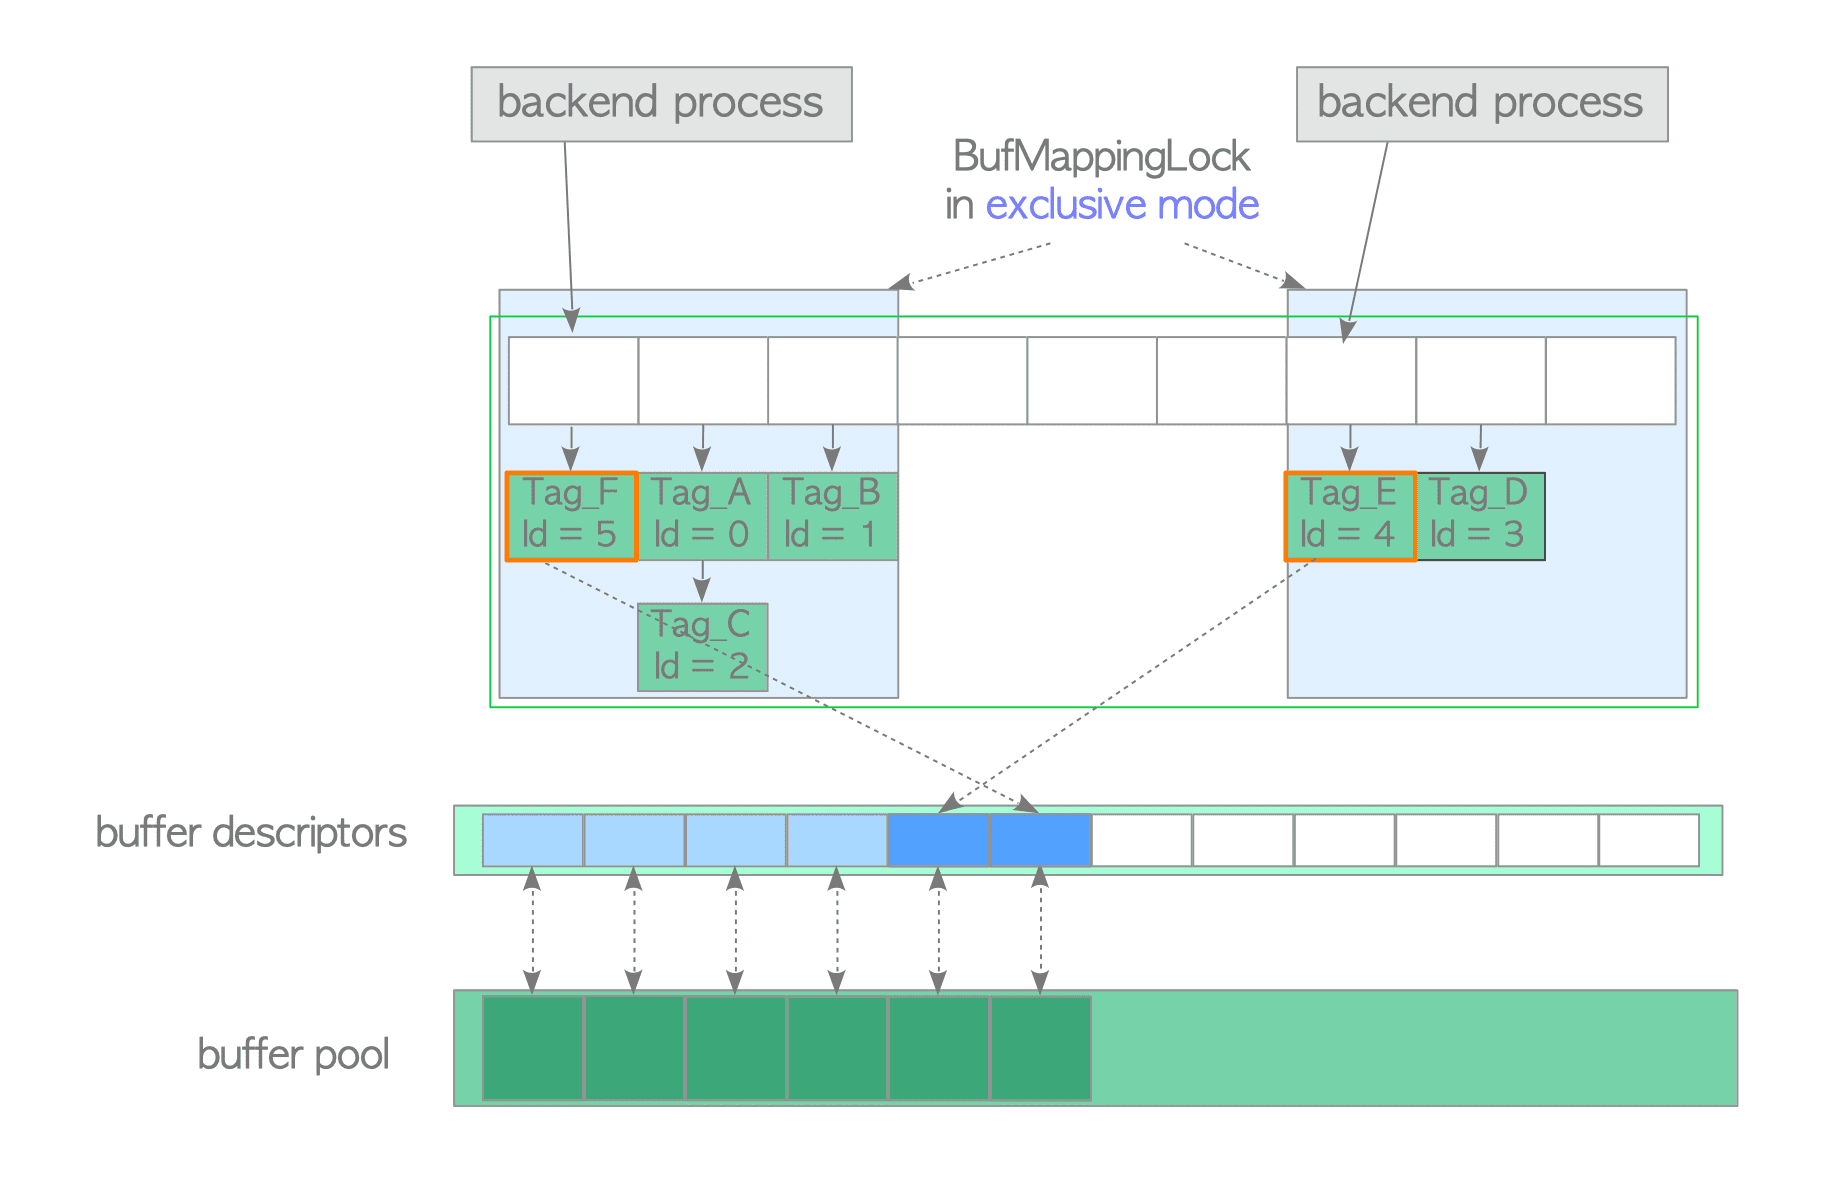

- 버퍼 테이블에는 다른 많은 잠금이 필요.
 - 예를 들어 버퍼 테이블은 내부적으로 스핀 잠금을 사용하여 항목을 삭제.
 - 그러나 기타 잠금에 대한 설명은 이 문서에서 필요하지 않으므로 생략.

**Info**
- PostgreSQL 버전 9.4까지 BufMappingLock은 기본적으로 16개의 개별 잠금으로 분할되었음.

# **Locks for Each Buffer Descriptor**

- 버전 9.5 이하에서는 각 버퍼 설명자가 두 개의 경량 잠금( content_lock 및 io_in_progress_lock )을 사용하여 해당 버퍼 풀 슬롯에 저장된 페이지에 대한 액세스를 제어.
  - 자체 필드(usage_count, refcount, flags)의 값을 확인하거나 변경할 때 스핀락(buf_hdr_lock)을 사용.

- 버전 9.6에서는 버퍼 액세스 방법이 개선.
  - io_in_progress_lock 및 스핀 잠금(buf_hdr_lock)이 제거.
  - 버전 9.6 이상에서는 이러한 잠금을 사용하는 대신 CPU 원자성 작업을 사용하여 해당 값을 검사하고 변경.

**content_lock**

- content_lock은 액세스 제한을 적용하는 일반적인 잠금.
  - 공유 및 독점 모드 에서 사용할 수 있음.

- 페이지를 읽을 때 백엔드 프로세스는 페이지를 저장하는 버퍼 설명자의 공유 content_lock을 획득.

**다음 중 하나를 수행하면 독점 content_lock이 획득**

- 저장된 페이지에 행(예: 튜플)을 삽입하거나 저장된 페이지 내 튜플의 t_xmin/t_xmax 필드를 변경. (행을 삭제하거나 업데이트할 때 연관된 튜플의 이러한 필드가 변경됨.)

- 저장된 페이지에서 튜플을 물리적으로 제거하거나 여유 공간을 압축 (Vacuum Processing과 HOT에 의해 수행됩니다 .)

- 저장된 페이지 내의 튜플을 동결.

**io_in_progress_lock(버전 9.5 이하)**

- 버전 9.5 이하에서는 버퍼의 I/O가 완료될 때까지 기다리는 데 io_in_progress 잠금이 사용
  - PostgreSQL 프로세스가 스토리지에서 페이지 데이터를 로드하거나 스토리지에 쓸 때 프로세스는 스토리지에 액세스하는 동안 해당 설명자의 독점적인 io_in_progress 잠금을 획득.

**spinlock(버전 9.5 이하)**

- 플래그 또는 기타 필드(예: refcount 및 Usage_count)를 확인하거나 변경할 때 스핀락이 사용.
- spinlock 사용법의 두 가지 구체적인 예는 다음과 같음.

1. 버퍼 설명자 고정:
  1. 버퍼 설명자의 스핀록을 획득.
  2. refcount 및 Usage_count 값을 1씩 늘림.
  3. 스핀록을 해제.

```
LockBufHdr(bufferdesc);    /* Acquire a spinlock */
bufferdesc->refcont++;
bufferdesc->usage_count++;
UnlockBufHdr(bufferdesc); /* Release the spinlock */
```

2. 더티 비트를 '1'로 설정:
  1. 버퍼 설명자의 스핀록을 획득.
  2. 비트별 연산을 사용하여 더티 비트를 '1'로 설정.
  3. 스핀록을 해제.

```
#define BM_DIRTY             (1 << 0)    /* data needs writing */
#define BM_VALID             (1 << 1)    /* data is valid */
#define BM_TAG_VALID         (1 << 2)    /* tag is assigned */
#define BM_IO_IN_PROGRESS    (1 << 3)    /* read or write in progress */
#define BM_JUST_DIRTIED      (1 << 5)    /* dirtied since write started */

LockBufHdr(bufferdesc);
bufferdesc->flags |= BM_DIRTY;
UnlockBufHdr(bufferdesc);
```

- 다른 비트를 변경하는 것도 같은 방식으로 수행됨.